## Projet Fidelisini partie Machine Learning

In [2]:
import numpy as np
import pandas as pd

from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor


from tqdm import tqdm

# Deep Learning avec LightGBM

In [3]:
RANDOM_STATE = 42

# data import
data = pd.read_csv('train.csv', parse_dates=['Date'])
test_data = pd.read_csv('train.csv', parse_dates=['Date'])
sample_submission = pd.read_csv('submission.csv', parse_dates=['Date'])
n_train_days = int((data['Date'].max() - data['Date'].min()).days * 0.65)


In [4]:
def preprocess_data(data):
   
    result_data = pd.concat([], axis=1).fillna(-1)
    result_data['std'] = result_data[shift_columns].std(axis=1)
    result_data['mean'] = result_data[shift_columns].mean(axis=1)
    result_data['median'] = result_data[shift_columns].median(axis=1)
    result_data['min'] = result_data[shift_columns].min(axis=1)
    result_data['max'] = result_data[shift_columns].max(axis=1)

    return result_data


def calculate_score(model, val_data, n_val_days, past):
    prediction = pd.DataFrame()
    preprocessed_val_data = preprocess_data(val_data)
    for day in tqdm(range(n_val_days + 1)):
        dummy_row = past.iloc[[-1]]
        dummy_row.index = dummy_row.index + pd.DateOffset(days=1)
        past = pd.concat([past, dummy_row], axis=0)
        preprocessed_past = preprocess_data(past)
        pred = model.predict(preprocessed_past.drop(targets, axis=1).iloc[[-1]])
        prediction_row = pd.DataFrame(pred, columns=targets)
        prediction_row.index = past.iloc[[-1]].index
        prediction = pd.concat([prediction, prediction_row], axis=0)
        past.iloc[-1, :] = prediction_row.iloc[0, :]
    prediction.reset_index(inplace=True)
    temp_val = val_data.reset_index()
    prediction = temp_val[['date']].merge(prediction, on='date')
    score = mean_squared_error(val_data, prediction.drop('date', axis=1), squared=False)
    return score

In [5]:
# model parameters found by optuna

lgbm_params = {'n_estimators': 133,
          'learning_rate': 0.02160090575577129,
          'num_leaves': 17,
          'reg_lambda': 9.565258041853633,
          'reg_alpha': 0.8510455855003681,
          'max_depth': 8,
          'subsample': 0.9853030507684611,
          'colsample_bytree': 0.3386640122320139,
          'min_child_weight': 68,
          'min_child_samples': 32,
         'random_state': RANDOM_STATE,
         'boosting_type': 'gbdt'}

cb_params = {'n_estimators': 196,
             'l2_leaf_reg': 8.801409803806328e-06,
             'subsample': 0.8008259806287997,
             'max_depth': 6,
             'min_child_samples': 220,
             'colsample_bylevel': 0.3101405899929676,
             'random_state':42,
             'objective': 'RMSE',
             'eval_metric': 'RMSE',
             'bootstrap_type': 'Bernoulli',
             'sampling_frequency': 'PerTree',
             'logging_level': 'Silent',
             'od_type': 'Iter'}

xgb_params = {'lambda': 3.2834644371560267e-07,
              'alpha': 0.0033674483434975857,
              'colsample_bytree': 0.9931681116513553,
              'subsample': 0.9627374697387774,
              'n_estimators': 564,
              'max_depth': 12,
              'min_child_weight': 99,
             'tree_method':'gpu_hist',
             'random_state': RANDOM_STATE,
             'learning_rate': 0.01}

In [6]:
data.head()

,ID,Date,Age,Department,Gender,Religion,Experience,Workstyle,Skills,Availability,...,Brainstorming,Speed,TechnicalSkills,SoftSkills,Agreeableness,TM1,TM2,TM3,TM4,TM5
0,1,2021-07-22,31,Engineering,Female,Agnostic,7,Logical,Software Development,Full-time,...,0.78,0.83,0.94,0.76,0.750,0.603,4,2,1,3.0
1,2,2022-10-03,27,HR,Female,Catholic,5,People-oriented,Employee Training,Full-time,...,0.82,0.67,0.79,0.87,0.870,0.445,3,10,11,5.0
2,3,2021-03-11,33,Engineering,Male,Atheist,8,Analytical,Data Analysis,Full-time,...,0.93,0.73,0.87,0.97,0.635,1.000,7,5,6,NaN
3,4,2020-11-14,29,Marketing,Female,Agnostic,6,Creative,Content Creation,Full-time,...,0.84,0.63,0.75,0.87,0.847,11.000,4,9,3,NaN
4,5,2021-05-07,34,Finance,Male,Muslim,9,Detail-oriented,Financial Analysis,Part-time,...,0.76,0.87,0.96,0.76,0.598,5.000,2,11,8,NaN


In [7]:
max_train_date = data.index.max()
min_date = sample_submission['Date'].min()
max_date = sample_submission['Date'].max()

n_days = (max_date - min_date).days + 1
target= ['TM1', 'TM2', 'TM3', 'TM4']
targets = ['ID','Department','Skills','TM1', 'TM2', 'TM3', 'TM4', 'Agreeableness','PerfTaskBurn']
X, Y = data.drop(target, axis=1), data[targets]
X_test = sample_submission.drop(target, axis=1)


In [8]:
# Your code for defining models and fitting the data

prediction = pd.DataFrame()
past = Y.copy()
for day in tqdm(range(n_days + 1)):
    dummy_row = past.iloc[[-1]]
    dummy_row.index = dummy_row.index 
    past = pd.concat([past, dummy_row], axis=0)
    
    # Make predictions using the ensemble model
    prediction_row = pd.DataFrame(past, columns=targets)
    prediction = pd.concat([prediction, prediction_row], axis=0)

sample_submission.to_csv('lgbm_cb_xgb_ensembling_v1.csv', index=False)


100%|██████████| 1060/1060 [00:06<00:00, 162.16it/s]


# Prediction :

In [42]:
# Convert specific columns to integers and round them
cols_to_convert = ['ID','TM1', 'TM2', 'TM3', 'TM4']
prediction[cols_to_convert] = prediction[cols_to_convert].astype(int)

# Print the head of the updated prediction DataFrame
prediction.head(10)


,ID,Department,Skills,TM1,TM2,TM3,TM4,Agreeableness,PerfTaskBurn
0,1,Engineering,Software Development,0,4,2,1,0.750,0.85
1,2,HR,Employee Training,0,3,10,11,0.870,0.69
2,3,Engineering,Data Analysis,1,7,5,6,0.635,0.79
3,4,Marketing,Content Creation,11,4,9,3,0.847,0.72
4,5,Finance,Financial Analysis,5,2,11,8,0.598,0.83
5,6,HR,Conflict Resolution,8,7,5,2,0.769,0.79
6,7,Engineering,Problem Solving,8,11,9,10,0.581,0.84
7,8,Marketing,Marketing Strategy,2,9,10,4,0.993,0.70
8,9,Finance,Financial Planning,10,6,11,3,0.598,0.83
9,10,HR,Employee Relations,2,6,4,7,0.900,0.71


In [15]:
# Install required packages
import os
import torch

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Define the GNN model
class GNN(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GNN, self).__init__()
        self.conv1 = GATConv(num_features, 16, heads=8, dropout=0.6)
        self.conv2 = GATConv(16 * 8, num_classes, dropout=0.6)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Load the dataset
data = prediction.copy()

2.0.1+cpu


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [33 lines of output]
      No CUDA runtime is found, using CUDA_HOME='C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.1'
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-3.9
      creating build\lib.win-amd64-3.9\torch_scatter
      copying torch_scatter\placeholder.py -> build\lib.win-amd64-3.9\torch_scatter
      copying torch_scatter\scatter.py -> build\lib.win-amd64-3.9\torch_scatter
      copying torch_scatter\segment_coo.py -> build\lib.win-amd64-3.9\torch_scatter
      copying torch_scatter\segment_csr.py -> build\lib.win-amd64-3.9\torch_scatter
      copying torch_scatter\testing.py -> build\lib.win-amd64-3.9\torch_scatter
      copying torch_scatter\utils.py -> build\lib.win-amd64-3.9\torch_scatter
      copying torch_scatter\__init__.py -> build\lib.win-amd64-3.9\torch_scatt

# Personality compatibility in a team with Graphic Neural Network (GNN) :

2.0.1+cpu


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [33 lines of output]
      No CUDA runtime is found, using CUDA_HOME='C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v12.1'
      running bdist_wheel
      running build
      running build_py
      creating build
      creating build\lib.win-amd64-3.9
      creating build\lib.win-amd64-3.9\torch_scatter
      copying torch_scatter\placeholder.py -> build\lib.win-amd64-3.9\torch_scatter
      copying torch_scatter\scatter.py -> build\lib.win-amd64-3.9\torch_scatter
      copying torch_scatter\segment_coo.py -> build\lib.win-amd64-3.9\torch_scatter
      copying torch_scatter\segment_csr.py -> build\lib.win-amd64-3.9\torch_scatter
      copying torch_scatter\testing.py -> build\lib.win-amd64-3.9\torch_scatter
      copying torch_scatter\utils.py -> build\lib.win-amd64-3.9\torch_scatter
      copying torch_scatter\__init__.py -> build\lib.win-amd64-3.9\torch_scatt

Compatibility Graph for Engineering
Compatibility Graph for Marketing
Compatibility Graph for Finance
Compatibility Graph for HR
Compatibility Graph for IT


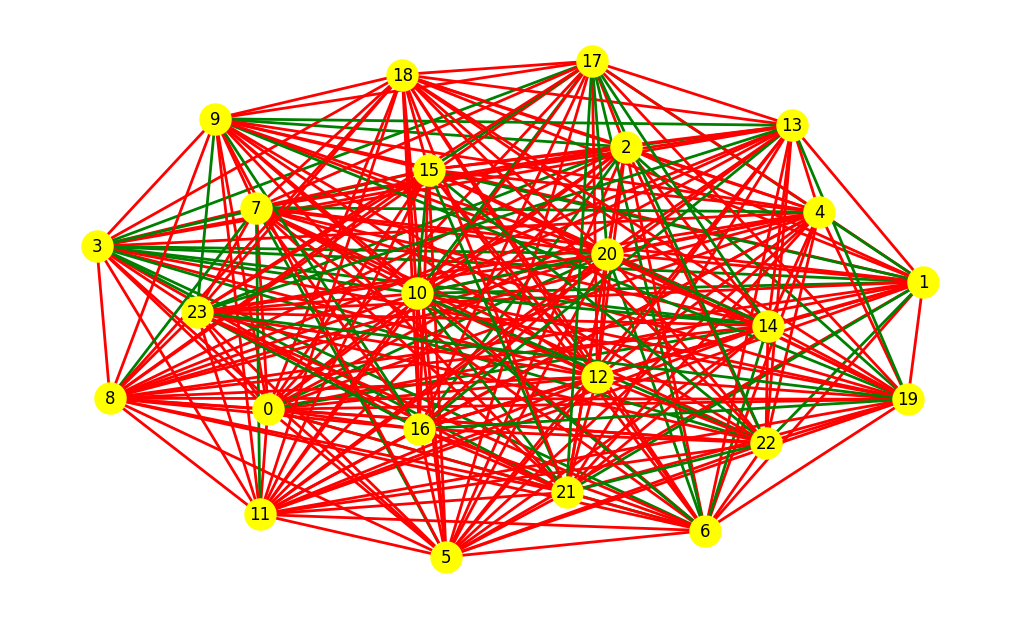

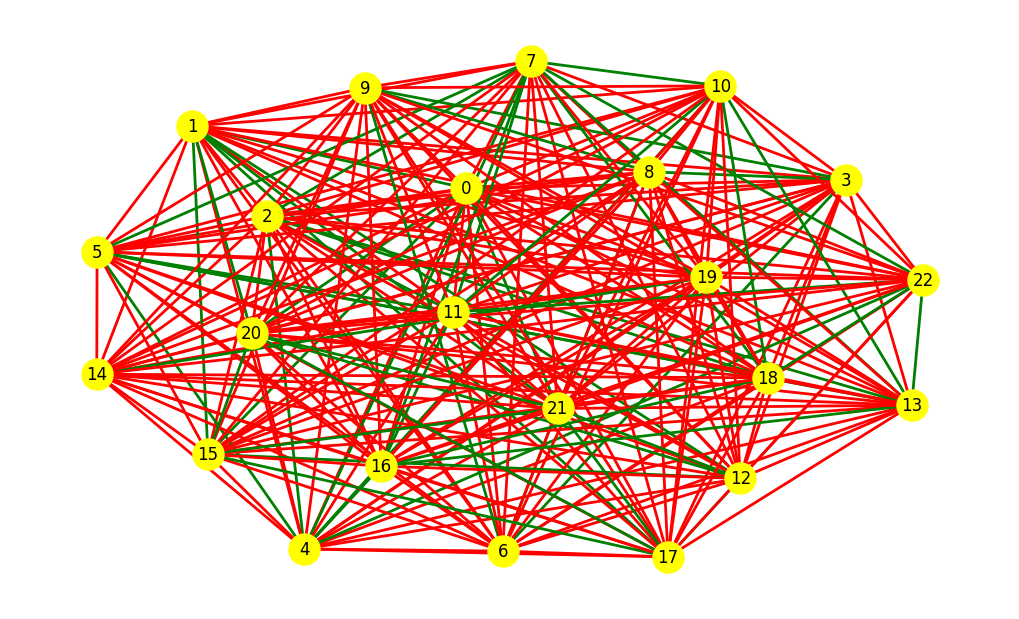

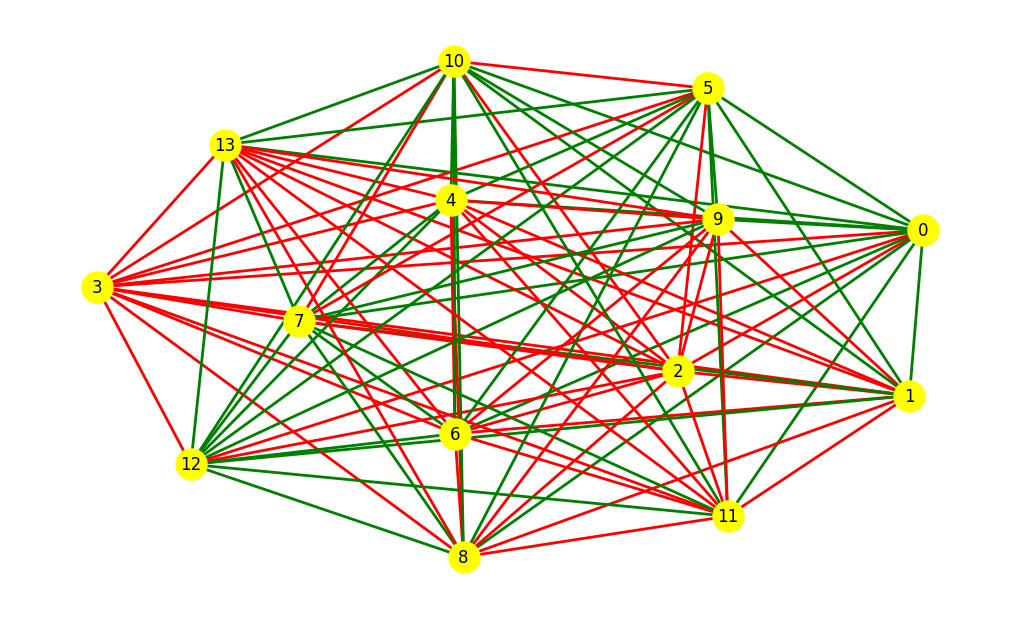

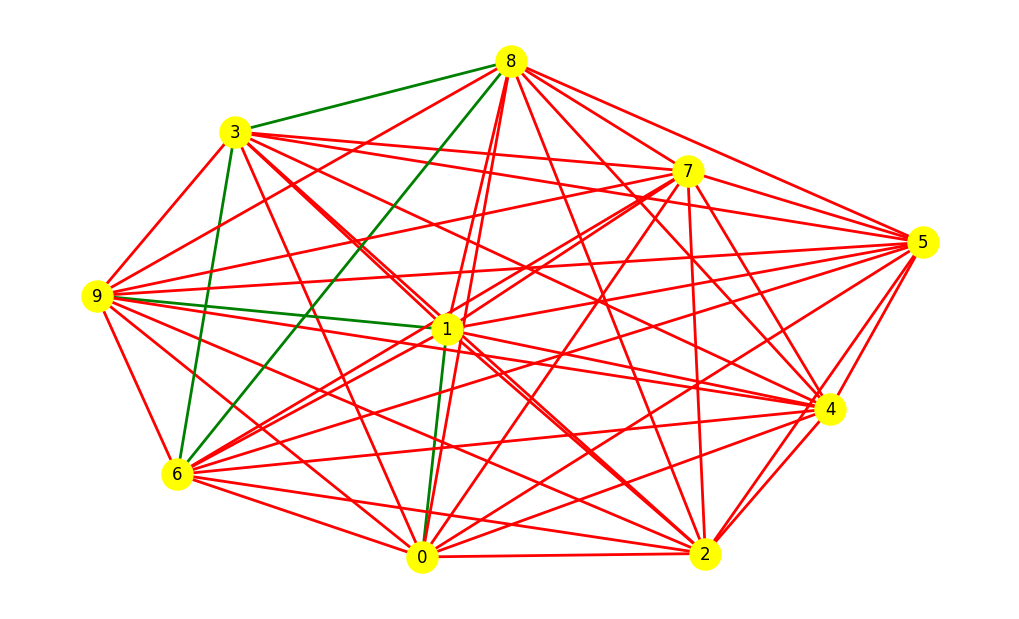

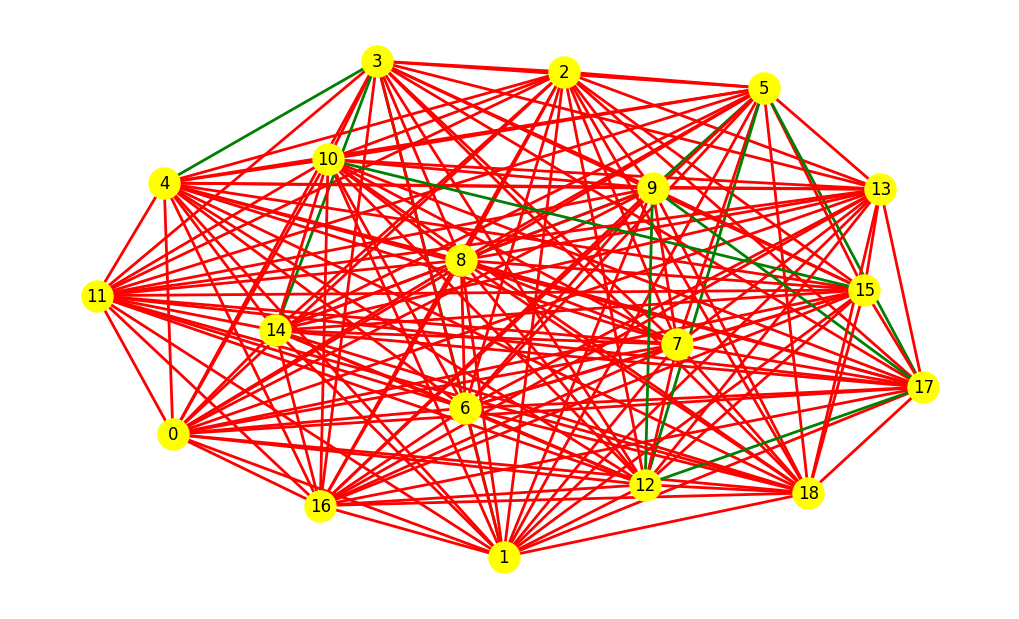

In [53]:
# Install required packages
import os
import torch

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Import libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GATConv
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Define the GNN model
class GNN(nn.Module):
    def __init__(self, num_features, num_classes):
        super(GNN, self).__init__()
        self.conv1 = GATConv(num_features, 16, heads=8, dropout=0.6)
        self.conv2 = GATConv(16 * 8, num_classes, dropout=0.6)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Load the dataset
data = pd.read_csv('h.csv')

# Preprocess the dataset
features = ['DISC Blue', 'DISC Red', 'DISC Green', 'DISC Yellow']
target = ['Balance', 'Performance']
num_features = len(features)
num_classes = len(target)

# Split data by department
departments = data['Department'].unique()

for department in departments:
    # Filter data for the current department
    department_data = data[data['Department'] == department].reset_index(drop=True)
    
    # Create a graph
    graph = nx.Graph()

    # Add nodes to the graph
    for index, row in department_data.iterrows():
        node_attributes = {
            'Name': row['Name'],
            'Age': row['Age'],
            'Department': row['Department'],
            'Gender': row['Gender'],
            'Stack': row['Stack']
        }
        graph.add_node(index, **node_attributes)

    # Add edges to the graph based on compatibility
    for i in range(len(department_data)):
        for j in range(i+1, len(department_data)):
            node_i = department_data.iloc[i]
            node_j = department_data.iloc[j]
            if (node_i['DISC Red'] == node_j['DISC Yellow'] and node_i['DISC Yellow'] == node_j['DISC Red']) or \
                    (node_i['DISC Blue'] == node_j['DISC Green'] and node_i['DISC Green'] == node_j['DISC Blue']):
                graph.add_edge(i, j, color='green')
            else:
                graph.add_edge(i, j, color='red')

    # Visualize the graph
    print(f'Compatibility Graph for {department}')
    plt.figure(figsize=(10, 6))
    pos = nx.spring_layout(graph)
    edge_colors = [graph[u][v]['color'] for u, v in graph.edges]
    nx.draw(graph, pos, with_labels=True, node_color='yellow', node_size=500, edge_color=edge_colors, width=2.0, edge_cmap=plt.cm.Reds)    
